In [ ]:
import numpy as np 
import pandas as pd 
import os


import spacy 
from gensim.models import FastText  

from PIL import Image

import glob

nlp = spacy.load("en_core_web_sm")

In [ ]:
class CFG:
    data_folder = '../input/h-and-m-personalized-fashion-recommendations/'
    emb_size = 20
    img_emb_size = 128
    cutoff = 2
    modelname = 'efficientnet_b0'

# Functions

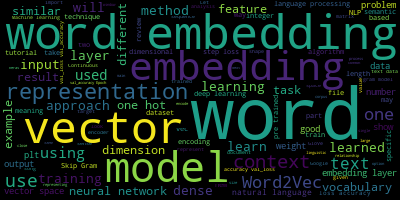

One thing that is pretty much guaranteed to be useful are embeddings for the products. We can go around creating them in different manners:

* based on the purchase history
* using the images
* using text info

My (as of yet unsubstantiated) hunch is that combining different embeddings can help with different info being available: while some products do not have images, while others might only have limited purchase history (hence methods like collaborative filtering might run into a [cold start problem](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems))).

We investigate those three manners below. The notebook is a work in progress, I will be adding more stuff as I figure it out :-) 

# Purchase history

This is 2022, so I think it's safe to assume most people reading this know what `word2vec` is and how it works ;-) The core part of the logic we care about is that words appearing in similar contexts are likely to have similar meanings. It is this formulation that allows us to leverage the approach in the context of identifying similarity of purchased items in the current competition: a list of items purchased by a user is similar structure-wise to a word sequence forming a sentence. 


In other words, we assume that if two items are bought together (contextual similarity in the case of words), then those two will be defined as ‘similar items’ by the algorithm. In the end, similar items will have embeddings in close proximity and ads from distinct sub-categories will end up with embeddings further away from each other in cosine similarity space. Since a picture is worth a thousand words, this might help develop the intuition:

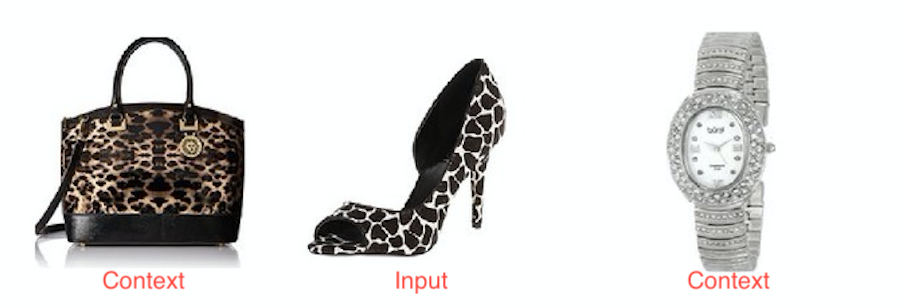

Below, we will use this analogy (`item2vec` ) to create representation for our items in the transaction dataset. We start by loading the entirety of the transaction data - since we are not using the target per specific user, we need not worry about leakage.

In [ ]:
xdat = pd.read_csv(CFG.data_folder + 'transactions_train.csv',
                  dtype={'article_id': str} )
xdat.head(3)

As a quick sanity check, we can have a look at the number of unique dimensions:

In [ ]:
# count the unique levels
print('unique articles: ' + str(xdat.article_id.nunique()))
print('unique customers: ' + str(xdat.customer_id.nunique()))
print('unique shopping: '+ str(len(xdat[['t_dat', 'customer_id']].drop_duplicates())) )

In [ ]:
# create our "sentences"
shopping_by_ud = xdat.groupby(['t_dat','customer_id'])['article_id'].apply(list).reset_index(name ='shopping_list')

# check the length - so we can filter out one-element lists (useless for this kind of embedding)
shopping_by_ud['list_size'] = shopping_by_ud.shopping_list.apply(len)

# drop sentences shorter than cutoff 
shopping_by_ud = shopping_by_ud.loc[shopping_by_ud.list_size >= CFG.cutoff]

The beauty of this approach is that while we can directly re-use 

In [ ]:
## train a fasttext model
shopping_model = FastText(vector_size = CFG.emb_size, window = 3, min_count=1, workers = 4)   
# there is a weird gensim bug that you can only pass the sentences as the first positional argument, but not named ?
shopping_model.build_vocab(shopping_by_ud.shopping_list)
shopping_model.train(shopping_by_ud.shopping_list.values, total_examples=len(shopping_by_ud), epochs=5)

In [ ]:
# create the embeddings for all elligible products
xlist = xdat.article_id.drop_duplicates()
prod_emb = xlist.apply(lambda x: shopping_model.wv[x]).values
prod_emb = np.array([e.reshape(1,-1) for e in prod_emb]).reshape(-1,CFG.emb_size)

# store in a friendly format for latter use :-) 
prod_emb = pd.DataFrame(prod_emb, columns = ['emb'+str(f) for f in range(CFG.emb_size)])
prod_emb['product_id'] = xlist
cols = list(prod_emb.columns)
cols = [cols[-1]] + cols[:-1]
prod_emb = prod_emb[cols]

prod_emb.to_csv('prodemb_shop_'+str(CFG.emb_size)+'.csv', index = False)

# Text data

In [ ]:
xdat = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/articles.csv')
xdat.head(3)

In [ ]:
xdat['detail_desc']

# Images

Code adapted from https://www.kaggle.com/titericz/imagenet-embeddings-plus-rapids-svr

In [ ]:
!pip install timm

In [ ]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [ ]:
# list all the images
img_list = glob.glob('../input/h-and-m-personalized-fashion-recommendations/images/*/*')

In [ ]:
# PyTorch setup

class timmDataset:
    def __init__(self, path, modelcfg=None):
        
        self.path = path
        self.transform = create_transform(**modelcfg)
        
        
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, item):
        
        impath = self.path[item]
        img = Image.open(impath).convert('RGB')
        img = self.transform(img) # PIL image
        return img
    
    
train_dataset = timmDataset(
    img_list,
    modelcfg = resolve_data_config({},model = CFG.modelname)
)


train_dataloader = DataLoader(train_dataset, batch_size= 128, num_workers = 2, shuffle=False)
    

In [ ]:
# extraction model
class EmbModel(nn.Module):
    def __init__(self, model_name= CFG.modelname, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.img_emb_size)

    def forward(self, x):
        x = self.model(x)
        return x    

# efficientnet version
class EmbModel2(nn.Module):
    def __init__(self, model_name, n_class = CFG.img_emb_size, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)

    def forward(self, x):
        x = self.model(x)
        return x


model = EmbModel2(CFG.modelname, pretrained=True)    
model.to("cuda")

In [ ]:
allpreds = []

with torch.no_grad():
    for a in tqdm(train_dataloader):
        preds = model(a.to("cuda"))
        preds = preds.detach().cpu().numpy()
        allpreds.append(preds)


In [ ]:
allpreds = np.concatenate(allpreds)
img_embeddings = pd.DataFrame(allpreds)
img_embeddings.columns = ['emi_'+str(f) for f in range(img_embeddings.shape[1])]
img_embeddings['image_id'] = img_list

cols = list(img_embeddings.columns)
cols = [cols[-1]] + cols[:-1]
img_embeddings = img_embeddings[cols]

img_embeddings.to_csv('prodemb_img_'+str(CFG.img_emb_size)+'.csv', index = False)